In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
#from torchview import draw_graph
import matplotlib.pyplot as plt
import numpy as np
from auxiliary.visualization import plot_raster
from auxiliary.evaluation import calculate_conf_matrix, calculate_metrics

In [2]:
# Metal device enables running the code on the GPU on MacOS (analogous to CUDA)
device = torch.device("mps")

In [3]:
# operators are always specified in this order
operator_order = ("elimination", "aggregation", "typification", "displacement", "enlargement")

In [4]:
# Define DIN font for plots
plt.rcParams["font.family"] = "DIN Alternate"

### Loading the data

In [5]:
# Setting up a Dataset object for DataLoader
class BuildingRasterDataset(Dataset):
    def __init__(self, path, transform=None):
        '''Loads and unpacks the data from the compressed .npz format'''
        data = np.load(path)
        
        # Read raster maps
        blocks_rasterized = data["blocks"].copy()
        # Read generalization operators
        targets_eli = data["elimination"].copy()
        targets_agg = data["aggregation"].copy()
        targets_typ = data["typification"].copy()
        targets_dis = data["displacement"].copy()
        targets_enl = data["enlargement"].copy()
        targets_sim = data["simplification"].copy()
        
        # Read target uuids
        self.uuid = data["uuids"].copy()

        # Check whether all parts have the same dimensionality
        assert blocks_rasterized.shape[0] == self.uuid.shape[0] == targets_eli.shape[0] == targets_agg.shape[0] == targets_typ.shape[0] \
        == targets_dis.shape[0] == targets_enl.shape[0] == targets_sim.shape[0]

        # Convert numpy array to tensor with shape (n_samples, 3, height, width)
        self.block = torch.from_numpy(blocks_rasterized).float()
        
        # Convert generalization operators to tensor
        self.elimination = torch.from_numpy(targets_eli).float()
        self.aggregation = torch.from_numpy(targets_agg).float()
        self.typification = torch.from_numpy(targets_typ).float()
        self.displacement = torch.from_numpy(targets_dis).float()
        self.enlargement = torch.from_numpy(targets_enl).float()
        self.simplification = torch.from_numpy(targets_sim).float()

        # store transformation
        self.transform = transform

    def __len__(self):
        '''Enables dataset length calculation'''
        return self.uuid.shape[0]

    def __getitem__(self, index):
        '''Enables indexing, returns uuid and block raster as features and generalization operators as label'''
        uuid = self.uuid[index]
        block = self.block[index]
        eli = self.elimination[index]
        agg = self.aggregation[index]
        typ = self.typification[index]
        dis = self.displacement[index]
        enl = self.enlargement[index]
        sim = self.simplification[index]

        if self.transform:
            block = self.transform(block)

        return uuid, block, eli, agg, typ, dis, enl, sim

### Training pipeline

1) Design model (input, output size, forward pass)
2) Construct loss and optimizer
3) Training loop
     * Forward pass: Compute prediction
     * Backward pass: Compute gradients
     * Update weights

### Model design

Stride refers to the number of positions that the convolutional kernel shifts at one step. Input channel size of one layer should always be equal to the output channel size of the previous layer.

The application of convolution and pooling layers decreases the size of the image: The output after a convolution can be calculated according to the following formula, where $W$ is the input width, $F$ is the kernel size, $P$ is the padding and $S$ is the stride:

$$\frac{(W-F + 2 P)}{S} + 1$$

In [6]:
class RasterModel(nn.Module):
    def __init__(self):
        super(RasterModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # in_features of first fully-connected layer are calculated by multiplying number of output channels of last convolutional layer
        # by (image size after all pooling operations)^2
        self.fc1 = nn.Linear(in_features=128 * 32 * 32, out_features=512)
        # the last fully-connected layer has five output neurons, one for each generalization operator
        self.fc2 = nn.Linear(in_features=512, out_features=5)

    def forward(self, x):
        # input dimension = 256
        x = self.pool(F.relu(self.conv1(x)))
        # input dimension = 128
        x = self.pool(F.relu(self.conv2(x)))
        # input dimension = 64
        x = self.pool(F.relu(self.conv3(x)))
        # input dimension = 32
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        # BCE loss requires sigmoid activation function at the end (conversion of logits to probabilities)
        #x = torch.sigmoid(self.fc2(x))
        # BCEWithLogitsLoss applies sigmoid internally for loss computation
        # this means that model outputs are logits, they have to be passed through sigmoid for evaluation
        x = self.fc2(x)
        # squeezing the result to ensure common dimensionality between input and output
        #x = torch.squeeze(x)
        return x

# Creating model and moving to device
model = RasterModel()
model.to(device)

RasterModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=131072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=5, bias=True)
)

In [7]:
learning_rate = 0.001

criterion = nn.BCEWithLogitsLoss() # Binary cross-entropy loss, applies a sigmoid internally and takes logits as input
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Loss and activation function

Softmax is a common activation function, (binary) cross-Entropy is a common loss function for multiclass classification problems, sigmoid is commonly used for binary classification problems. When using the Pytorch implementation: no softmax in the last layer, class labels not one-hot encoded and no softmax. BCELoss requires an activation function at the end! Sigmoid are usually the last layers in binary classification probems.

If you don't know which activation function to use, just use ReLU, Leaky ReLU tries to adress vanishing gradient problem. Multiplies input with small negative numbers, as normal ReLU may cause many gradients to become zero, which means that the weights will never be updated. Whenever weights are not updated during training, use Leaky ReLU.

I am dealing with a multilabel (for each generalization operator), binary (operator present or absent) classification problem.

### Training loop

In [8]:
num_epochs = 10
batch_size = 4

data = "../training_samples.nosync/raster/raster_building_data.npz"

# composing various random transforms that should be applied to the data
transform = transforms.Compose(
    [transforms.RandomRotation(degrees=(0,360)),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomVerticalFlip(p=0.5)])

train_dataset = BuildingRasterDataset(data, transform=transform)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

total_samples = len(train_dataset)
n_iterations = math.ceil(total_samples/batch_size)

# saving the losses from every epoch
train_losses = []

for epoch in range(num_epochs):
    # tracking loss per epoch
    train_running_loss = 0.0
    n_batches = 0
    for i, (uuid, block, eli, agg, typ, dis, enl, sim) in enumerate(train_dataloader): 
        n_batches += 1
        # moving the features to device
        block, eli, agg, typ, dis, enl = block.to(device), eli.to(device), agg.to(device), typ.to(device), dis.to(device), enl.to(device)

        # concatenate the operators: The first output neuron will indicate presence or absence of elimination, the second aggregation...
        operators = torch.stack([eli, agg, typ, dis, enl], dim=1).float()

        # empty the gradients
        optimizer.zero_grad()
        
        # forward pass
        pred_operators = model(block) # compute predictions, calls forward method under the hood
        loss = criterion(pred_operators, operators) # calculate loss
        train_running_loss += loss.item() # tracking running loss to keep track of the loss for every epoch

        # backward pass
        loss.backward() # backpropagation
        optimizer.step() # update the parameters

        # print information every few batches
        if not (i + 1) % 5:
            print(f"epoch {epoch+1}/{num_epochs}, step {i+1}/{n_iterations}")

    # print information at the end of each epoch
    train_loss_epoch = train_running_loss / n_batches
    train_losses.append(train_loss_epoch)
    print(f"epoch {epoch+1} finished, loss: {train_loss_epoch:.3f}")

epoch 1 finished, loss: 0.572
epoch 2 finished, loss: 0.487
epoch 3 finished, loss: 0.482
epoch 4 finished, loss: 0.497
epoch 5 finished, loss: 0.469
epoch 6 finished, loss: 0.423
epoch 7 finished, loss: 0.430
epoch 8 finished, loss: 0.427
epoch 9 finished, loss: 0.409
epoch 10 finished, loss: 0.403


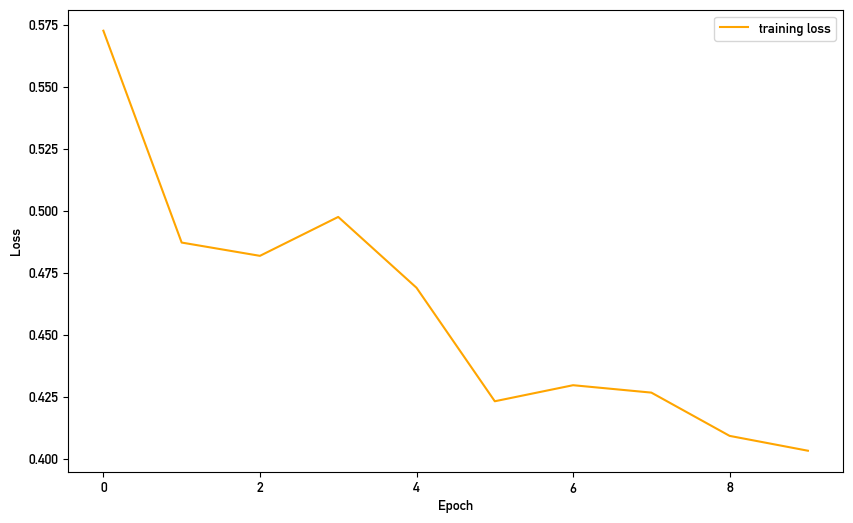

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, color="orange", label="training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Evaluation and metrics

In [10]:
test_dataset = BuildingRasterDataset(data)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# stores the confusion matrices for every operator
metrics = {}

for operator_name in operator_order:
    metrics[operator_name] = {}
    metrics[operator_name]["tp"] = 0
    metrics[operator_name]["fp"] = 0
    metrics[operator_name]["tn"] = 0
    metrics[operator_name]["fn"] = 0

# prediction evaluations should not be part of the computational graph, gradients should not be tracked
with torch.no_grad():
    for uuid, block, eli, agg, typ, dis, enl, sim in test_dataloader:
        # moving the features to device
        block, eli, agg, typ, dis, enl = block.to(device), eli.to(device), agg.to(device), typ.to(device), dis.to(device), enl.to(device)

        # concatenate the operators: The first output neuron will indicate presence or absence of elimination, the second aggregation...
        operators = torch.stack([eli, agg, typ, dis, enl], dim=1).float()

        # prediction on the trained model results in logits, sigmoid needs to be applied to obtain probabilities
        pred_operators = torch.sigmoid(model(block))
        pred_operators_labels = (pred_operators > 0.5).float()  # thresholding

        # calculating metrics for the individual operators
        for i, operator_name in enumerate(operator_order):
            operator = operators[:, i]
            pred_operator = pred_operators_labels[:, i]

            tp, fp, tn, fn = calculate_conf_matrix(operator, pred_operator)

            metrics[operator_name]["tp"] += tp
            metrics[operator_name]["fp"] += fp
            metrics[operator_name]["tn"] += tn
            metrics[operator_name]["fn"] += fn

for operator_name in operator_order:
    accuracy, precision, recall, f1_score = calculate_metrics(metrics[operator_name]["tp"],
                                                              metrics[operator_name]["fp"],
                                                              metrics[operator_name]["tn"],
                                                              metrics[operator_name]["fn"])
    
    print(f"{operator_name.upper()}: Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1_score:.3f}")

ELIMINATION: Accuracy: 1.000, Precision: 0.000, Recall: 0.000, F1-score: 0.000
AGGREGATION: Accuracy: 0.750, Precision: 0.000, Recall: 0.000, F1-score: 0.000
TYPIFICATION: Accuracy: 0.875, Precision: 0.000, Recall: 0.000, F1-score: 0.000
DISPLACEMENT: Accuracy: 0.750, Precision: 0.750, Recall: 1.000, F1-score: 0.857
ENLARGEMENT: Accuracy: 0.750, Precision: 0.750, Recall: 1.000, F1-score: 0.857


### Saving the model

https://debuggercafe.com/multi-label-image-classification-with-pytorch-and-deep-learning/

### Ideas

* Investigate effect of building size on the prediction quality? Other "confounding" factors.
* See whether including the roads actually increases the prediction performance.
* Investigate effects of imbalanced data / operator distribution.